# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
azdias2 = azdias
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print(azdias2.shape)

(891221, 85)


In [4]:
#print the first few rows
azdias2.head(n=5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


 **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
#number of missing values before conversion

azdias2.isnull().sum().sum()

4896838

In [6]:
#number of missing values of each columns
azdias2.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [7]:
#converting the unknown or missing values in each column to nan
for value in range(len(feat_info)):
    missing_or_unknown = feat_info.iloc[value]['missing_or_unknown']
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip(']')
    missing_or_unknown = missing_or_unknown.split(sep=",")
    inner_values = []
    for inner in missing_or_unknown:
        if(inner != 'X' and inner != 'XX' and inner != ''):
            inner = int(inner)
        else:
            inner = inner
        inner_values.append(inner)
    missing_or_unknown = inner_values
    if missing_or_unknown != ['']:
        azdias2.replace({feat_info.iloc[value]['attribute'] : missing_or_unknown}, np.nan, inplace=True)
    

In [8]:
#number of missing values after conversion

azdias2.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [9]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias2.isnull().sum()


AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

<Container object of 85 artists>

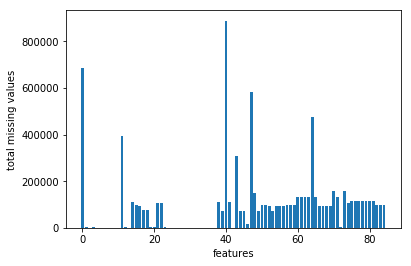

In [10]:
# Investigate patterns in the amount of missing data in each column.
y = azdias2.isnull().sum(axis=0).values #missing value in each column
x = feat_info.index #name of the column
plt.xlabel("features")
plt.ylabel("total missing values")
plt.bar(x, y)


(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

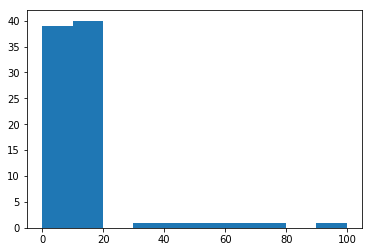

In [11]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
missing_data_percent_cols = y/azdias2.shape[0]*100 #percent of data missing in each column
plt.hist(missing_data_percent_cols)

In [12]:
feaure_names = azdias2.columns
high_missing_data_cols = []
high_missing_data_values = []
zero_missing_data_cols = []

for i in range(len(missing_data_percent_cols)):
    if (missing_data_percent_cols[i] > 30.0):
        high_missing_data_cols.append(feaure_names[i])
        high_missing_data_values.append(missing_data_percent_cols[i])
    elif(missing_data_percent_cols[i] == 0):
        zero_missing_data_cols.append(feaure_names[i])

In [13]:
print("zero missing value columns: ", zero_missing_data_cols)
print("==================")
print("high missing value columns: ", high_missing_data_cols)
print("==================")
print(high_missing_data_values)


print("This columns have highest missing or unknown value.") 



zero missing value columns:  ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'ZABEOTYP']
high missing value columns:  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
[76.955435296071343, 44.02028228688507, 99.757635872583791, 34.813699407890972, 65.596748730112949, 53.468668265222654]
This columns have highest missing or unknown value.


#### Discussion 1.1.2: Assess Missing Data in Each Column
columns which have 30% more missing or unknown values columns discard from the evaluation process 
discarded columns = 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [14]:
# How much data is missing in each row of the dataset?

azdias2.isnull().sum(axis=1)

0         49
1          4
2          4
3          9
4          3
5          2
6          5
7          4
8          4
9          3
10         3
11        53
12        10
13        11
14        53
15        11
16         9
17        53
18         9
19         5
20        16
21         6
22         6
23        11
24        53
25         9
26        24
27         5
28         4
29         4
          ..
891191     1
891192     4
891193     2
891194     2
891195     2
891196     2
891197     2
891198     4
891199     5
891200     5
891201     3
891202     5
891203    20
891204     2
891205     3
891206     3
891207     2
891208     6
891209     5
891210     4
891211     4
891212     4
891213     3
891214     4
891215     5
891216     6
891217     7
891218     9
891219     5
891220     6
Length: 891221, dtype: int64

In [15]:
# Write code to divide the data into two subsets based on the number of missing
nan_raw = azdias2.isnull().sum(axis=1)
nan_raw = pd.DataFrame(nan_raw)
nan_raw.columns = ['nan_counts']
subset_1 = azdias2.iloc[nan_raw[nan_raw['nan_counts']>=20].index.tolist()]
subset_2 = azdias2.iloc[nan_raw[nan_raw['nan_counts']<20].index.tolist()]

subset_1_rows = subset_1.index.tolist()
print("no of rows have high missing or unknown values:", len(subset_1_rows))

no of rows have high missing or unknown values: 99325


COMPARISON OF DATA DISTRIBUTION IN HIGH MISSING ROWS AND FEW OR NO MISSING ROWS OF ZERO MISSING COLUMNS
We compares only first six columns here
zero missing columns for comparison: ['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER']


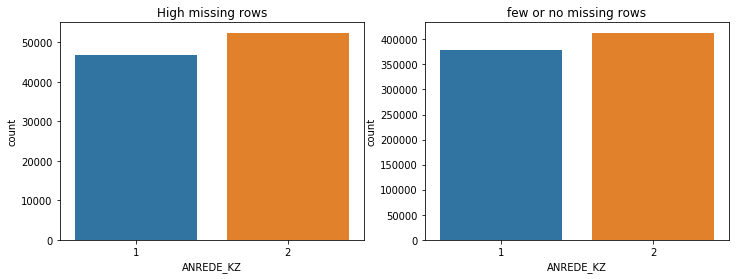

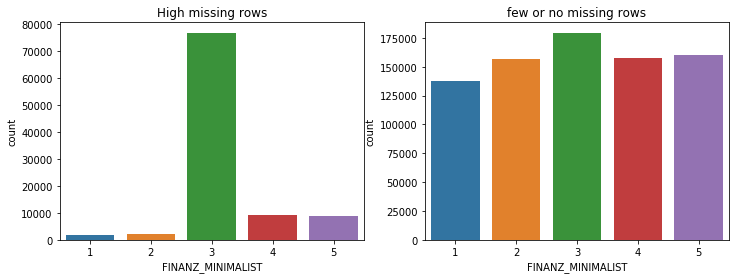

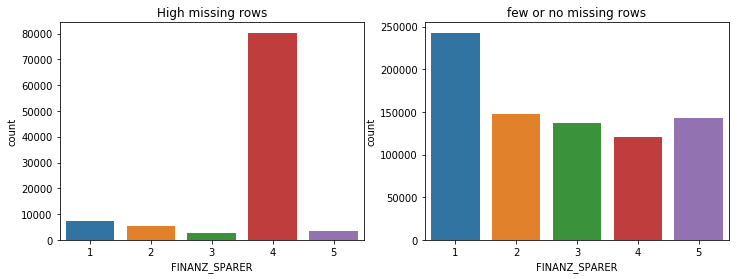

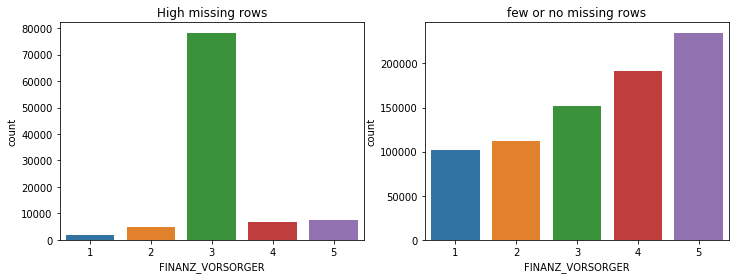

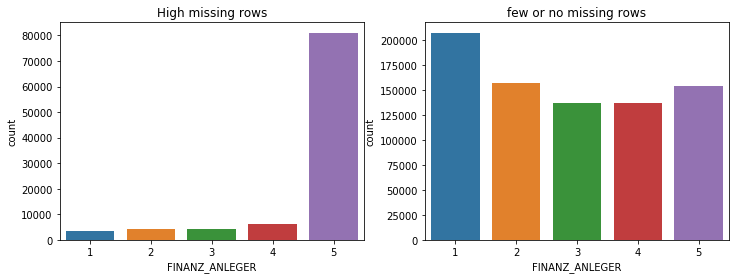

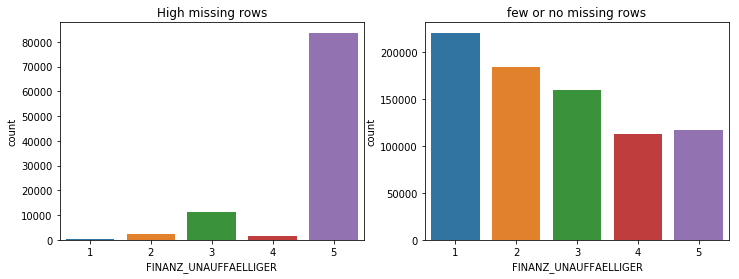

In [16]:
# values in each rows
print("COMPARISON OF DATA DISTRIBUTION IN HIGH MISSING ROWS AND FEW OR NO MISSING ROWS OF ZERO MISSING COLUMNS")
print("========================")
print("We compares only first six columns here")



print("zero missing columns for comparison:", zero_missing_data_cols[:6])

for col_name in zero_missing_data_cols[:6]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].set_title("High missing rows")
    sns.countplot(subset_1[col_name], ax=ax[0])
    ax[1].set_title("few or no missing rows")
    sns.countplot(subset_2[col_name], ax=ax[1])



In [17]:
print("high missinng or unknown values of the columns and count of missing values")
print(azdias2[high_missing_data_cols].isnull().sum())

high missinng or unknown values of the columns and count of missing values
AGER_TYP        685843
GEBURTSJAHR     392318
TITEL_KZ        889061
ALTER_HH        310267
KK_KUNDENTYP    584612
KBA05_BAUMAX    476524
dtype: int64


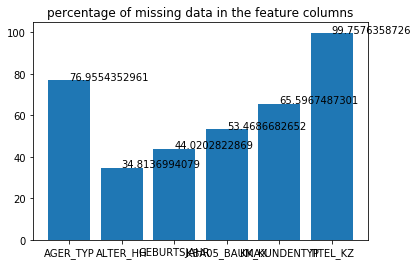

In [18]:
#distribution of high missing values in the columns

plt.bar(high_missing_data_cols, high_missing_data_values)
plt.title("percentage of missing data in the feature columns")
for i in range(len(high_missing_data_values)):
    plt.annotate(str(high_missing_data_values[i]), xy = (high_missing_data_cols[i], high_missing_data_values[i]) )
plt.show()


 1. dropping columns which has high percentage of missing or unknown data = high_missing_data_cols
 
 2. dropping rows which has high missing or unknown values = subset_1


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
azdias3 = azdias2.drop(high_missing_data_cols, axis=1)
#azdias3 = azdias3.drop()
azdias3 = azdias3.drop(subset_1.index)
print(azdias3.shape)
print("number of columns after dropping columns which have high missing values: ", azdias3.shape[1])
print("number of rows after dropping subset_1 which have high missing or unknown values: ", azdias3.shape[0])

(791896, 79)
number of columns after dropping columns which have high missing values:  79
number of rows after dropping subset_1 which have high missing or unknown values:  791896


In [20]:
#feature data after removing the columns
feat_info_new = feat_info[feat_info['attribute'].isin(azdias3.columns)]

#### Discussion 1.1.3: Assess Missing Data in Each Row

removes rows which has more than 20 'unknown or missing' numbers from the dataframe.
from comparison its clear that removal of rows not makes much difference  data in dataframes

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [21]:
# How many features are there of each data type?
feat_info_new['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [22]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#categorical features
feature_cat = feat_info_new[feat_info_new['type']== 'categorical']

binary_cat_cols = []
multi_cat_cols = []
for x in azdias3[feature_cat.attribute]:
    #print(len(feature_cat.attribute))
    len_cols = azdias3[x].unique()
    len_cols = [x for x in len_cols if str(x) != 'nan']
    if(len(len_cols) == 2):
        binary_cat_cols.append(x)
    else:
        multi_cat_cols.append(x)

print("binary categories:", binary_cat_cols)

binary categories: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']


In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
new_values = {'W':0, 'O':1 }


azdias3 = azdias3.replace({'OST_WEST_KZ':new_values})


In [24]:
azdias4 = azdias3.drop(multi_cat_cols, axis=1)
azdias4.shape

(791896, 66)

In [25]:
print("no of columns after keeping and encoding the binary columns:", azdias4.shape[1])

no of columns after keeping and encoding the binary columns: 66


#### Discussion 1.2.1: Re-Encode Categorical Features

only binary categories retaines other multilevel categories drops from evaluation
out of this binary categories 'OST_WEST_KZ' have non-numeric values 'w' and 'o' so  need to convert these values to numbers for doing evaluation process. so replacing these values with '0' and '1'

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [26]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feature_mix = feat_info_new[feat_info_new['type'] == 'mixed'].attribute #mixed category features

#PRAEGENDE_JUGENDJAHRE feature is a combination of decade and movement

azdias4 =pd.concat([azdias4, azdias4["PRAEGENDE_JUGENDJAHRE"].rename('DECADE')], axis=1)
azdias4 =pd.concat([azdias4, azdias4["PRAEGENDE_JUGENDJAHRE"].rename('MOVEMENT')], axis=1)

#"CAMEO_INTL_2015" feature is a combination of wealth and life stage
azdias4 =pd.concat([azdias4, azdias4["CAMEO_INTL_2015"].rename('WEALTH')], axis=1)
azdias4 =pd.concat([azdias4, azdias4["CAMEO_INTL_2015"].rename('LIFE_STAGE')], axis=1)

decade_values = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
movement_values = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

#replacing with new values
azdias4['DECADE'].replace(decade_values, inplace=True)
azdias4['MOVEMENT'].replace(movement_values, inplace=True)


In [27]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
wealth_values = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                 '21':2, '22':2, '23':2, '24':2, '25':2, 
                 '31':3, '32':3, '33':3, '34':3, '35':3, 
                 '41':4, '42':4, '43':4, '44':4, '45':4, 
                 '51':5, '52':5, '53':5, '54':5, '55':5 }
life_stage_values = {'11':1, '12':2, '13':3, '14':4, '15':5, 
                 '21':1, '22':2, '23':3, '24':4, '25':5, 
                 '31':1, '32':2, '33':3, '34':4, '35':5, 
                 '41':1, '42':2, '43':3, '44':4, '45':5, 
                 '51':1, '52':2, '53':3, '54':4, '55':5 }

azdias4['WEALTH'].replace(wealth_values, inplace=True)
azdias4['LIFE_STAGE'].replace(life_stage_values, inplace=True)


In [28]:
feature_mix = feat_info_new[feat_info_new['type'] == 'mixed'].attribute

azdias5 = azdias4.drop(feature_mix, axis=1)
print("no of columns: ", azdias5.shape[1])

no of columns:  64


In [29]:
print(azdias5.shape)

(791896, 64)


#### Discussion 1.2.2: Engineer Mixed-Type Features

columns 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015' is a combination of two features. separtes these 'mixed' features and encodes these values to integer values for evaluation process. all other mixed features drops from the data frame 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.


1. keeps all numeric interval and ordinal type columns
2. binary categorical features all included and encode the column 'OST_WEST_KZ' which has non integer values
3. removed all multi level category features from the dataframe
4. mixed features "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" separated to different columns. and then drops all mixed type features


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [30]:
def clean_data(df):
    
    for value in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[value]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=",")
        inner_values = []
        for inner in missing_or_unknown:
            if(inner != 'X' and inner != 'XX' and inner != ''):
                inner = int(inner)
            else:
                inner = inner
            inner_values.append(inner)
        missing_or_unknown = inner_values
        if missing_or_unknown != ['']:
            df.replace({feat_info.iloc[value]['attribute'] : missing_or_unknown}, np.nan, inplace=True)
    print("converted unknown or missing numbers to nan")
    
    y = df.isnull().sum(axis=0).values
    missing_data_percent_cols = y/df.shape[0]*100
    feaure_names = df.columns
    high_missing_data_cols = []
    high_missing_data_values = []
    zero_missing_data_cols = []
    
    #finding the columns to drop
    for i in range(len(missing_data_percent_cols)):
        if (missing_data_percent_cols[i] > 30.0):
            high_missing_data_cols.append(feaure_names[i])
            high_missing_data_values.append(missing_data_percent_cols[i])
        elif(missing_data_percent_cols[i] == 0):
            zero_missing_data_cols.append(feaure_names[i])
            
    #finding the rows to drop
    nan_raw = df.isnull().sum(axis=1)
    nan_raw = pd.DataFrame(nan_raw)
    nan_raw.columns = ['nan_counts']
    subset_1 = df.iloc[nan_raw[nan_raw['nan_counts']>=20].index.tolist()]
    subset_2 = df.iloc[nan_raw[nan_raw['nan_counts']<20].index.tolist()]
    subset_1_rows = subset_1.index.tolist()
    df2 = df.drop(high_missing_data_cols, axis=1)
    df2 = df2.drop(subset_1.index)
    print("drops high missing or unknown columns and rows")
    
    
    feat_info_new = feat_info[feat_info['attribute'].isin(df2.columns)]
    feature_cat = feat_info_new[feat_info_new['type']== 'categorical']
    binary_cat_cols = []
    multi_cat_cols = []
    for x in azdias2[feature_cat.attribute]:
    #print(len(feature_cat.attribute))
        len_cols = df2[x].unique()
        len_cols = [x for x in len_cols if str(x) != 'nan']
        if(len(len_cols) == 2):
            binary_cat_cols.append(x)
        else:
            multi_cat_cols.append(x)
            
    new_values = {'W':0, 'O':1 }
    df2 = df2.replace({'OST_WEST_KZ':new_values})
    df3 = df2.drop(multi_cat_cols, axis=1)
    print("only binary category columns included, multilevel columns excluded")
    
    
    feature_mix = feat_info_new[feat_info_new['type'] == 'mixed'].attribute #mixed category features

    #PRAEGENDE_JUGENDJAHRE feature is a combination of decade and movement

    df3 =pd.concat([df3, df3["PRAEGENDE_JUGENDJAHRE"].rename('DECADE')], axis=1)
    df3 =pd.concat([df3, df3["PRAEGENDE_JUGENDJAHRE"].rename('MOVEMENT')], axis=1)

    #"CAMEO_INTL_2015" feature is a combination of wealth and life stage
    df3 =pd.concat([df3, df3["CAMEO_INTL_2015"].rename('WEALTH')], axis=1)
    df3 =pd.concat([df3, df3["CAMEO_INTL_2015"].rename('LIFE_STAGE')], axis=1)

    decade_values = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    movement_values = {1:1, 2:2, 3:1, 4:2, 5:1, 6:2, 7:2, 8:1, 9:2, 10:1, 11:2, 12:1, 13:2, 14:1, 15:2}

    #replacing with new values
    df3['DECADE'].replace(decade_values, inplace=True)
    df3['MOVEMENT'].replace(movement_values, inplace=True)
    
    wealth_values = {'11':1, '12':1, '13':1, '14':1, '15':1, 
                 '21':2, '22':2, '23':2, '24':2, '25':2, 
                 '31':3, '32':3, '33':3, '34':3, '35':3, 
                 '41':4, '42':4, '43':4, '44':4, '45':4, 
                 '51':5, '52':5, '53':5, '54':5, '55':5 }
    life_stage_values = {'11':1, '12':2, '13':3, '14':4, '15':5, 
                 '21':1, '22':2, '23':3, '24':4, '25':5, 
                 '31':1, '32':2, '33':3, '34':4, '35':5, 
                 '41':1, '42':2, '43':3, '44':4, '45':5, 
                 '51':1, '52':2, '53':3, '54':4, '55':5 }

    df3['WEALTH'].replace(wealth_values, inplace=True)
    df3['LIFE_STAGE'].replace(life_stage_values, inplace=True)
    
    feature_mix = feat_info_new[feat_info_new['type'] == 'mixed'].attribute
    print("all mixed features removed from the dataframe")
    df4 = df3.drop(feature_mix, axis=1)
    print(df4.shape)
    
    return df4

In [31]:
test = azdias
test = clean_data(test)
test.head(n=2)

converted unknown or missing numbers to nan
drops high missing or unknown columns and rows
only binary category columns included, multilevel columns excluded
all mixed features removed from the dataframe
(791896, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [32]:
#number of missing values in the dataframe after cleaning
azdias5.isnull().sum().sum()

670646

In [33]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp= Imputer(missing_values='NaN', strategy='mean')
azdias6 = imp.fit_transform(azdias5)
azdias6 = pd.DataFrame(azdias6)

In [34]:
#number of missing values after applying Imputer
azdias6.isnull().sum().sum()

0

In [35]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias6 = scaler.fit_transform(azdias6)


In [36]:
print(azdias6.shape)

(791896, 64)


### Discussion 2.1: Apply Feature Scaling

converts all nan values from the dataframe by using Imputer and then transformes the data using standardScaler

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.
pca = PCA(n_components=azdias6.shape[1])

In [38]:
# Investigate the variance accounted for by each principal component.
xpca = pca.fit(azdias6)


In [39]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

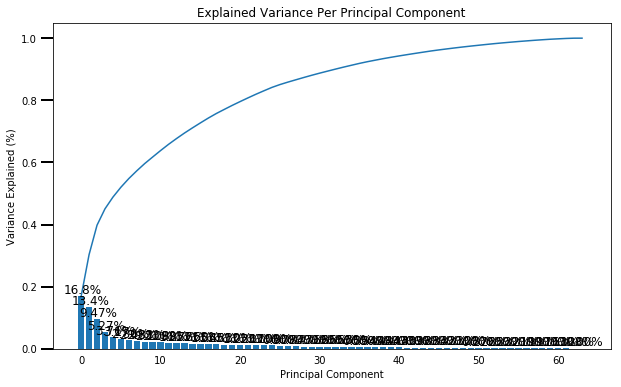

In [40]:
scree_plot(pca)

In [41]:
# Re-apply PCA to the data while selecting for number of components to retain.
from sklearn.decomposition import PCA
pca_30 = PCA(n_components=30)
xpca_30 = pca_30.fit_transform(azdias6)


In [42]:
weights = pd.DataFrame(pca_30.components_[0])
weights.index = azdias5.columns

In [43]:
weights.columns = ['PC_1']

In [44]:
weights = weights.sort_index(by=['PC_1'], ascending=False)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [45]:
weights

,PC_1
PLZ8_ANTG3,0.227538
PLZ8_ANTG4,0.220711
WEALTH,0.208150
HH_EINKOMMEN_SCORE,0.204578
ORTSGR_KLS9,0.198234
EWDICHTE,0.196484
FINANZ_HAUSBAUER,0.163578
PLZ8_ANTG2,0.154814
KBA05_ANTG4,0.153722
ARBEIT,0.144438


### Discussion 2.2: Perform Dimensionality Reduction
re applies the  feature scaling by retaining the no of components reduced to 30. it covers more than 80% of the variance explained


### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [46]:
def map_weights(pc_no, pca):
    weights = pd.DataFrame(pca.components_[pc_no])
    weights.index = azdias5.columns
    column_name = 'PC_'+ str(pc_no)
    weights.columns = [column_name]
    weights = weights.sort_index(by=[column_name], ascending=False)
    print(weights)

In [47]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

map_weights(0, pca_30)


                           PC_0
PLZ8_ANTG3             0.227538
PLZ8_ANTG4             0.220711
WEALTH                 0.208150
HH_EINKOMMEN_SCORE     0.204578
ORTSGR_KLS9            0.198234
EWDICHTE               0.196484
FINANZ_HAUSBAUER       0.163578
PLZ8_ANTG2             0.154814
KBA05_ANTG4            0.153722
ARBEIT                 0.144438
FINANZ_SPARER          0.142773
ANZ_HAUSHALTE_AKTIV    0.136567
RELAT_AB               0.136247
KBA05_ANTG3            0.135865
SEMIO_PFLICHT          0.111728
SEMIO_REL              0.108807
DECADE                 0.097662
SEMIO_RAT              0.091584
SEMIO_TRADV            0.085123
SEMIO_MAT              0.076090
SEMIO_FAM              0.075339
REGIOTYP               0.073256
FINANZ_UNAUFFAELLIGER  0.070433
SEMIO_KULT             0.069625
FINANZ_ANLEGER         0.066163
OST_WEST_KZ            0.054125
KKK                    0.044132
SEMIO_SOZ              0.041914
PLZ8_HHZ               0.041746
SEMIO_KAEM             0.040659
...     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [48]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(1, pca_30)

                           PC_1
ALTERSKATEGORIE_GROB   0.261283
FINANZ_VORSORGER       0.234231
SEMIO_ERL              0.230951
SEMIO_LUST             0.184139
RETOURTYP_BK_S         0.164122
W_KEIT_KIND_HH         0.119239
SEMIO_KRIT             0.115008
FINANZ_HAUSBAUER       0.114895
SEMIO_KAEM             0.111050
ANREDE_KZ              0.089440
PLZ8_ANTG3             0.089067
EWDICHTE               0.088477
ORTSGR_KLS9            0.087002
PLZ8_ANTG4             0.085022
WEALTH                 0.071328
SEMIO_DOM              0.069780
FINANZ_MINIMALIST      0.069331
KBA05_ANTG4            0.066076
ARBEIT                 0.065027
RELAT_AB               0.062600
PLZ8_ANTG2             0.061413
WOHNDAUER_2008         0.061017
ANZ_HAUSHALTE_AKTIV    0.060734
HH_EINKOMMEN_SCORE     0.052833
KBA05_ANTG3            0.040478
VERS_TYP               0.033379
ANZ_HH_TITEL           0.030518
OST_WEST_KZ            0.024643
REGIOTYP               0.020708
PLZ8_HHZ               0.012160
...     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [49]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

map_weights(2, pca_30)

                           PC_2
SEMIO_VERT             0.345552
SEMIO_SOZ              0.262897
SEMIO_FAM              0.250424
SEMIO_KULT             0.235415
FINANZ_MINIMALIST      0.155844
RETOURTYP_BK_S         0.108634
FINANZ_VORSORGER       0.100688
W_KEIT_KIND_HH         0.090724
ALTERSKATEGORIE_GROB   0.078552
SEMIO_REL              0.070566
SEMIO_LUST             0.064425
SEMIO_MAT              0.055279
GREEN_AVANTGARDE       0.047455
ORTSGR_KLS9            0.046099
MOVEMENT               0.045567
EWDICHTE               0.045526
PLZ8_ANTG4             0.044891
PLZ8_ANTG3             0.044485
ARBEIT                 0.034432
WOHNDAUER_2008         0.033148
RELAT_AB               0.031403
PLZ8_ANTG2             0.029704
WEALTH                 0.027249
KBA05_ANTG4            0.026672
ANZ_HAUSHALTE_AKTIV    0.025270
OST_WEST_KZ            0.015005
ANZ_HH_TITEL           0.013291
VERS_TYP               0.013004
ANZ_TITEL              0.009732
KBA05_ANTG3            0.007667
...     

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [50]:
pca_30.explained_variance_.sum()

56.346819726973237

### Discussion 2.3: Interpret Principal Components

First component 

positive: PLZ8_ANTG3, PLZ8_ANTG4 & WEALTH
negative : MOBI_REGIO, PLZ8_ANTG1 

Number of 6-10 family houses in macro cell regions,  Number of 10+ family houses in macro cell regions and  wealth positively influence the first component 
share of the movement and Number of 1-2 family houses for the macro cell  negatively affects the component 

Second component

positive: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER
negative: DECADE, SEMIO_REL

Age and Finance positively influence the second component
share of the generation by decade and personality negatively affects the component   

Third component:

positive: SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM
negative: SEMIO_DOM, SEMIO_KAEM, ANREDE_KZ

Dreamful, socialy minded and family minded personality positively influence the first component
share of dominant minded, combative attitude and gender negatively affects the component


(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
# Over a number of different cluster counts...
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)

    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    print(score)
    print(center)

    return score


    # run k-means clustering on the data and...
    
scores = []
centers = list(range(1,20))
    # compute the average within-cluster distances.
    
    

44619996.9886
1
38192515.3895
2
34937382.0906
3
32853942.4067
4
31394972.2005
5
30160274.3875
6
29033550.7276
7
28173955.6983
8
27408923.2357
9
27012264.8238
10
26585914.2118
11
25850430.8984
12
25534211.9186
13
25283662.597
14
24923146.3652
15
24660208.1391
16
24426641.2354
17
23787722.8189
18
23416825.3715
19


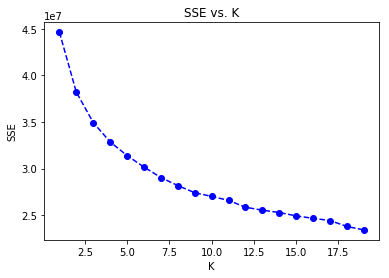

In [52]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
for center in centers:
    scores.append(get_kmeans_score(xpca_30, center))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');


In [52]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
model = KMeans(n_clusters=14)
labels = model.fit_predict(xpca_30)


In [53]:
general_data = labels

### Discussion 3.1: Apply Clustering to General Population

Apply the elbow method to find the best 'k' value
from the graph it is clear that change happens after k=14

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [55]:
customers.head(n=3)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0


In [56]:
# Apply preprocessing, feature transformation, and clustering from the general
#preprocessinng
customers_processed = clean_data(customers)
print(customers_processed.index)
#transformation
customers_transformed = imp.fit_transform(customers_processed)
customers_transformed = pd.DataFrame(customers_transformed)
from sklearn.decomposition import PCA
scaler = StandardScaler()
customer_scaled = scaler.fit_transform(customers_transformed)
pca = PCA(n_components=30)
xpca = pca.fit_transform(customer_scaled)

# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
kmeans = KMeans(n_clusters=14)
customers_data = kmeans.fit_predict(xpca)
customers_data

converted unknown or missing numbers to nan
drops high missing or unknown columns and rows
only binary category columns included, multilevel columns excluded
all mixed features removed from the dataframe
(140978, 62)
Int64Index([     0,      2,      3,      4,      5,      6,      7,      8,
                 9,     11,
            ...
            191641, 191642, 191643, 191644, 191645, 191646, 191647, 191649,
            191650, 191651],
           dtype='int64', length=140978)


array([8, 4, 5, ..., 9, 2, 5], dtype=int32)

In [57]:
customers_data

array([8, 4, 5, ..., 9, 2, 5], dtype=int32)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [58]:
#y = sorted(general_data.items())
from collections import Counter
Counter(customers_data)

Counter({8: 16228,
         4: 11564,
         5: 18605,
         3: 4283,
         13: 14775,
         12: 7339,
         1: 11276,
         2: 10345,
         6: 10705,
         9: 14206,
         7: 11557,
         0: 7298,
         11: 2510,
         10: 287})

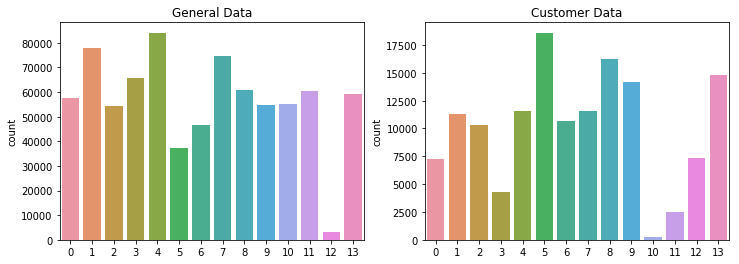

In [59]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].set_title("General Data")
sns.countplot(general_data, ax=ax[0])
ax[1].set_title("Customer Data")
sns.countplot(customers_data, ax=ax[1])



In [68]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
centroid_5 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[5]))

In [69]:
overrepresented = pd.Series(data = centroid_5, index = customers_processed.columns)
overrepresented

ALTERSKATEGORIE_GROB        3.729557
ANREDE_KZ                   1.033222
FINANZ_MINIMALIST           4.846375
FINANZ_SPARER               1.073522
FINANZ_VORSORGER            4.927600
FINANZ_ANLEGER              1.445404
FINANZ_UNAUFFAELLIGER       1.495856
FINANZ_HAUSBAUER            2.360330
GREEN_AVANTGARDE            0.014053
HEALTH_TYP                  2.012205
RETOURTYP_BK_S              3.785167
SEMIO_SOZ                   4.632455
SEMIO_FAM                   4.607104
SEMIO_REL                   3.428101
SEMIO_MAT                   3.176901
SEMIO_VERT                  6.147085
SEMIO_LUST                  5.593037
SEMIO_ERL                   4.581637
SEMIO_KULT                  4.688527
SEMIO_RAT                   2.419296
SEMIO_KRIT                  3.003570
SEMIO_DOM                   2.858439
SEMIO_KAEM                  2.541024
SEMIO_PFLICHT               2.747174
SEMIO_TRADV                 2.902442
SOHO_KZ                     0.009511
VERS_TYP                    1.425390
A

In [70]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
centroid_10 = scaler.inverse_transform(pca.inverse_transform(kmeans.cluster_centers_[10]))
underepresented = pd.Series(data = centroid_10, index = customers_processed.columns)
underepresented

ALTERSKATEGORIE_GROB        3.697217
ANREDE_KZ                   1.491385
FINANZ_MINIMALIST           2.544299
FINANZ_SPARER               1.097134
FINANZ_VORSORGER            4.918448
FINANZ_ANLEGER              1.100620
FINANZ_UNAUFFAELLIGER       1.093825
FINANZ_HAUSBAUER            4.623614
GREEN_AVANTGARDE            0.223612
HEALTH_TYP                  1.698089
RETOURTYP_BK_S              4.368033
SEMIO_SOZ                   4.594292
SEMIO_FAM                   3.911805
SEMIO_REL                   2.471155
SEMIO_MAT                   3.962807
SEMIO_VERT                  4.544222
SEMIO_LUST                  6.352126
SEMIO_ERL                   5.463707
SEMIO_KULT                  2.894079
SEMIO_RAT                   2.340529
SEMIO_KRIT                  4.587912
SEMIO_DOM                   4.377609
SEMIO_KAEM                  4.069785
SEMIO_PFLICHT               1.915111
SEMIO_TRADV                 1.773753
SOHO_KZ                     0.016716
VERS_TYP                    1.638788
A

### Discussion 3.3: Compare Customer Data to Demographics Data

Number of 6-10 and 10+ family houses in the region and Household types
Life stage Age and finance is popular with mail order company



> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.